##### Syed Ali Alim Rizvi

ref:
folds: https://gist.github.com/dsparks/3695362

# Prediction Uncertainty with Bootstrapping

In [1]:
library(reshape2)
library(ggplot2)

Warning message:
"package 'reshape2' was built under R version 3.5.1"Warning message:
"package 'ggplot2' was built under R version 3.5.1"

#### KNN Regression

In [2]:
# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3){
    ## count number of train samples
    train.len <- nrow(train.data)
    
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= 'euclidean'))[1:test.len, (test.len+1):(test.len+train.len)]
       
    #create storage for regression predictions
    test.label <- rep(0,test.len)
    
    ## for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        
        ###... and calculate the predicted labels according to the majority vote
        #test.label[i]<- (majority(train.label[nn]))
        test.label[i]<- (mean(train.label[nn]))
    }
    
    ## return the class labels as output
    return (test.label)
}

#### Boot function

In [3]:
# define a function that generates sample indixes based on bootstrap technique
boot <- function (original.size=100, sample.size=original.size, times=100){
    set.seed(123)
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}

In [4]:
# just to see if it works!
#boot(100, 10, 5)

In [5]:
t1b.train <- read.csv('KNN_Bootstrap_train.csv')
t1b.test <- read.csv('KNN_Bootstrap_test.csv')

In [6]:
train.data <- t1b.train[,-5]
train.label <- t1b.train[,5]
test.data <- t1b.test[,-5]
test.label <- t1b.test[,5]

In [7]:

# fix the parameters 
K <- 20           # Maximum K for KNN 
L <- 100           # number of datasets
N <- 30          # size of datasets

# generate bootstrap indices:
boot.indx <- boot(nrow(train.data), N, L)

# a dataframe to track the number of missclassified samples in each case
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

# THIS MAY TAKE A FEW MINUTES TO COMPLETE
## for every k values:
for (k in 1:K){
    
    ### for every dataset sizes:
    for (l in 1:L){
        
        #### calculate iteration index i
        i <- (k-1)*L+l
        
        #### save sample indices that were selected by bootstrap
        indx <- boot.indx[l,]
        
        #### save the value of k and l
        miss[i,'K'] <- k
        miss[i,'L'] <- l
        
        #### calculate and record the train and test missclassification rates
        miss[i,'test'] <-  sum((test.label - knn(train.data[indx, ], train.label[indx], test.data, K=k))^2)
    
    } 
}

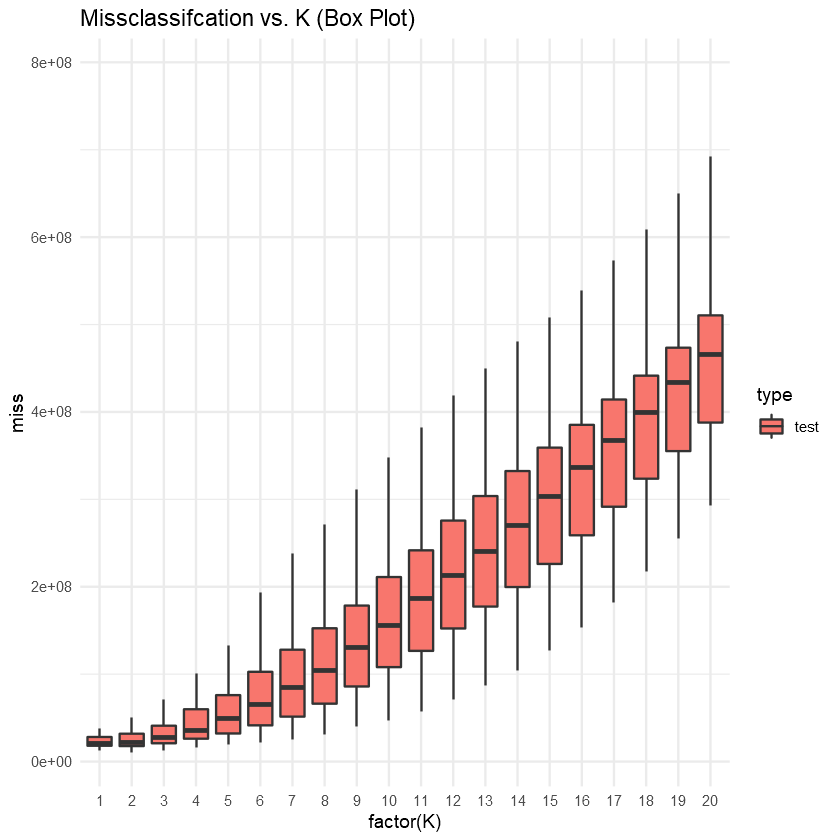

In [8]:
# plot misclassification percentage for train and test data sets
miss.m <- melt(miss, id=c('K', 'L')) # reshape for visualization
names(miss.m) <- c('K', 'L', 'type', 'miss')

ggplot(data=miss.m[miss.m$type=='test',], aes(factor(K), miss,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Box Plot)') + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

#### Check with different number of datasets for bootstrapping

In [9]:
start.time <- Sys.time()



# fix the parameters 
k <- 10           # K for KNN 
L <- seq(10,200,10) # number of datasets
N <- 30          # size of datasets

# a matrix to track the number of missclassified samples in each case
miss <- matrix(ncol = 2, nrow = 0)

### for every dataset sizes:
for (l in L){
    
    # generate bootstrap indices:
    boot.indx <- boot(nrow(train.data), N, l)
    
    for (i in 1:l) {

        #### save sample indices that were selected by bootstrap
        indx <- boot.indx[i,]
        
        #save value for L and MSE
        miss <- rbind(miss, c(l, sum((test.label - knn(train.data[indx, ], train.label[indx], test.data, K=k))^2)/N))
   
    }
} 

#convert matrix to dataframe
miss <- setNames(data.frame(miss), c("L", "test"))





end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 10.66209 mins

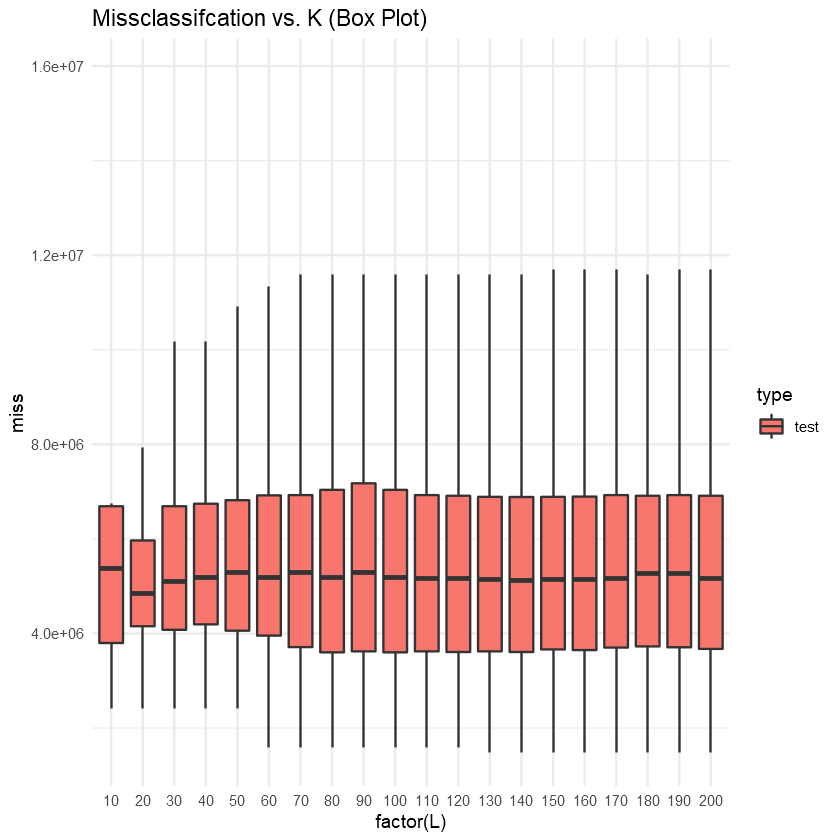

In [10]:
# plot misclassification percentage for train and test data sets
miss.m <- melt(miss, id=c('L')) # reshape for visualization
names(miss.m) <- c('L', 'type', 'miss')

ggplot(data=miss.m[miss.m$type=='test',], aes(factor(L), miss,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Missclassifcation vs. K (Box Plot)') + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)